In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import mean_squared_error
from scipy import stats
import tensorflow as tf
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense
import pandas as pd
import csv
from datetime import datetime

2023-04-18 19:33:06.519366: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-18 19:33:06.836747: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-18 19:33:06.837855: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-18 19:33:08.345632: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
grid_path = os.path.join(os.path.dirname(os.getcwd()), "data", "interim", "grid_data.npy")

# Loading it ...
with open(grid_path, 'rb') as f:
    data = np.load(f)

data.shape

(76, 79, 8736, 11)

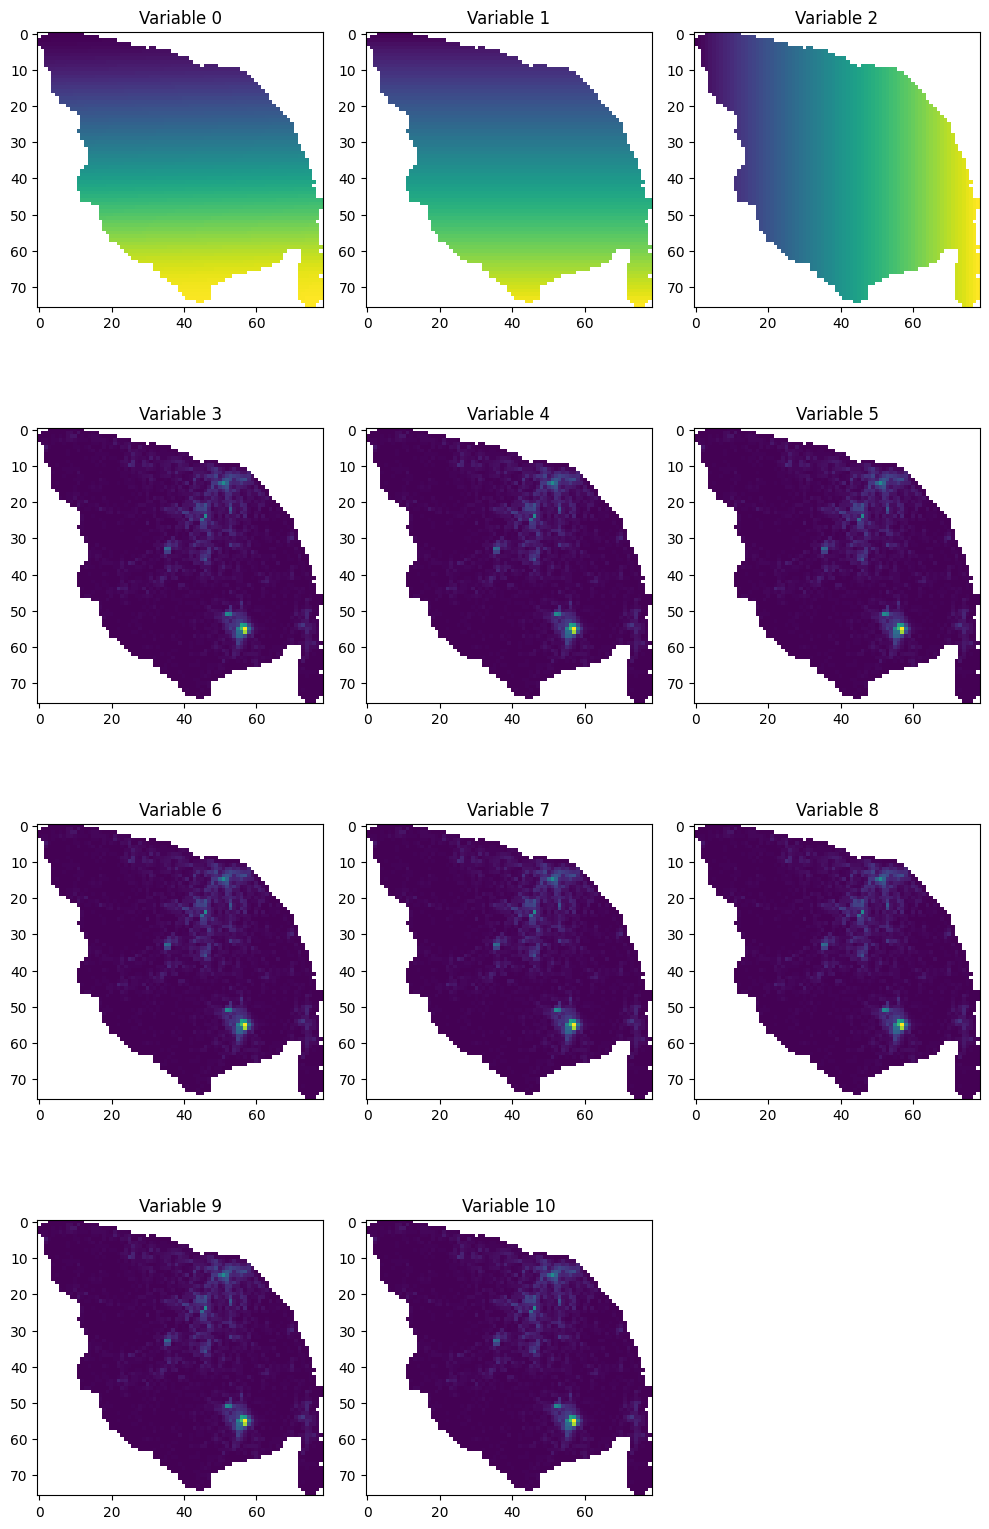

In [3]:
def plot_picture(grid_data, timestamp_index):
    num_vars = grid_data.shape[-1]
    num_rows = int((num_vars + 2) / 3)
    fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(10, 4*num_rows))
    var_list = range(num_vars)
    for var, ax in zip(var_list, axes.flatten()):
        if var < num_vars:
            ax.imshow(grid_data[:,:,timestamp_index,var], interpolation='nearest')
            ax.set_title(f'Variable {var}')
        else:
            ax.axis('off')
    if num_vars % 3 != 0:
        fig.delaxes(axes.flatten()[-1])
    plt.tight_layout()
    plt.show()
    return fig

show_plot = True

if show_plot:
    fig = plot_picture(grid_data = data, timestamp_index = 1000)

Model definition and train

In [4]:
# The depth of this model can be easily increased
# One could add more Conv layer
# Or increase the units on the LSTM to increase the model capability to fit the training data

# For now the model has only 136,167 parameters

def CNN_LSTM(input_shape, output_shape):
    ## Predicting the value of C1 for all the cells for only 1 timeStamp ahead (may be a waste for grid elements of no interest)
    model = tf.keras.Sequential()
    # define CNN model
    model.add(TimeDistributed(Conv2D(4, (2,2), activation='relu', padding='same', input_shape=input_shape)))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(TimeDistributed(Conv2D(1, (2,2), activation='relu', padding='same')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(TimeDistributed(Flatten()))
    # define LSTM model
    model.add(LSTM(units=25))
    # Final output - prediction for t+1 for each cell ID
    model.add(Dense(output_shape))

    model.build(input_shape) # input_shape is the shape of the input data
    model.summary()

    return model

In [5]:
N_IN_24_H = 24*4

In [6]:
def windowed_dataset(data, relevant_cells_mask, window_size, batch_size, shift):
    """
    """

    dataset = tf.data.Dataset.from_tensor_slices(data)
    dataset = dataset.window(window_size, shift=shift, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size))
    # This is providing C1 as the output, but maybe we want C1 + C2 ... 
    dataset = dataset.map(lambda window: (window[:-1], window[-1,:,:,0][relevant_cells_mask]))
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset


In [7]:
def ingestion(data, window_size, shift, batch_size):
    cell_ids = data[...,0,0]
    relevant_cells_mask = ~np.isnan(cell_ids)
    output_shape = relevant_cells_mask.sum()

    # Setting the timestep dim as the first dimensions
    data = np.transpose(data, (2, 0, 1, 3))
    print(f'Whole dataset shape: {data.shape}')

    # Using only the C's data
    x_data = data[...,3:]
    x_data[np.isnan(x_data)] = 0
    # Train/val split
    x_data_train = x_data[:int(x_data.shape[0]*2/3),...] 
    x_data_val = x_data[int(x_data.shape[0]*2/3):int(x_data.shape[0]*(2/3 + 1/6)),...]
    x_data_test = x_data[int(x_data.shape[0]*(2/3 + 1/6)):,...]

    train_dataset = windowed_dataset(x_data_train, relevant_cells_mask, window_size, batch_size, shift)
    validation_dataset = windowed_dataset(x_data_val, relevant_cells_mask, window_size, batch_size, shift)

    return train_dataset, validation_dataset, output_shape

In [8]:
def train(train_dataset, validation_dataset, input_shape, output_shape, lr, epochs, vis):
    model =CNN_LSTM(input_shape, output_shape)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    loss = tf.keras.losses.MeanSquaredError()
    model.compile(optimizer=optimizer, loss=loss)

    history = model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs)

    # summarize history for loss
    if vis:
        # list all data in history
        print(history.history.keys())

        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

    return model, history.history['loss'], history.history['val_loss']

In [9]:
def predict_evaluate(model, x_test, y_test):
    pred = model(x_test[np.newaxis,0:N_IN_24_H,...]).numpy()
    mse = mean_squared_error(y_test, pred)
    return pred, mse

# Run experiment

In [10]:
def experiment(data, window_size = N_IN_24_H+1, shift = 4, batch_size=32, lr=5e-3, epochs=100, vis=False, model_path='model.h5'):
    # Ingestion
    train_dataset, validation_dataset, output_shape = ingestion(data, window_size, shift, batch_size)
    input_shape = (None,96,76,79,8)

    # Train
    model, train_loss, val_loss = train(train_dataset, validation_dataset, input_shape, output_shape, lr, epochs, vis)
    model.save(model_path)

    ## We don't need this anymore, the fit method will take care of that for us
    # # Model prediction
    # relevant_cells_mask = ~np.isnan(data[...,0,0])
    # ground_truth = x_data_val_and_test[N_IN_24_H,...,0][relevant_cells_mask]
    # pred, mse = predict_evaluate(model, x_data_val_and_test, ground_truth)

    return train_loss, val_loss

To run single experiment:
`train_loss, pred, mse = experiment(data, window_size = N_IN_24_H+1, shift = 4, batch_size=32, lr=1e-2, vis=True)`

## Iterate over multiple window_sizes

Whole dataset shape: (8736, 76, 79, 11)


2023-04-18 19:33:22.306059: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2237906944 exceeds 10% of free system memory.
2023-04-18 19:33:24.519538: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 559092480 exceeds 10% of free system memory.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 96, 76, 79, 4)    132       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 96, 38, 39, 4)    0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 96, 38, 39, 1)    17        
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 96, 19, 19, 1)    0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 96, 361)          0

2023-04-18 19:33:25.196737: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-18 19:33:25.200521: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-18 19:33:25.203004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/2


2023-04-18 19:33:26.193281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [5824,76,79,8]
	 [[{{node Placeholder/_0}}]]
2023-04-18 19:33:26.193527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [5824,76,79,8]
	 [[{{node Placeholder/_0}}]]
2023-04-18 19:33:26.626950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/spl

      8/Unknown - 10s 872ms/step - loss: 603.7012

2023-04-18 19:33:37.009882: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1455,76,79,8]
	 [[{{node Placeholder/_0}}]]
2023-04-18 19:33:37.010168: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1455,76,79,8]
	 [[{{node Placeholder/_0}}]]
2023-04-18 19:33:37.350221: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/spl

8/8 [==============================] - 13s 1s/step - loss: 603.7012 - val_loss: 265.8746
Epoch 2/2
8/8 [==============================] - 10s 1s/step - loss: 596.1537 - val_loss: 260.4143
dict_keys(['loss', 'val_loss'])


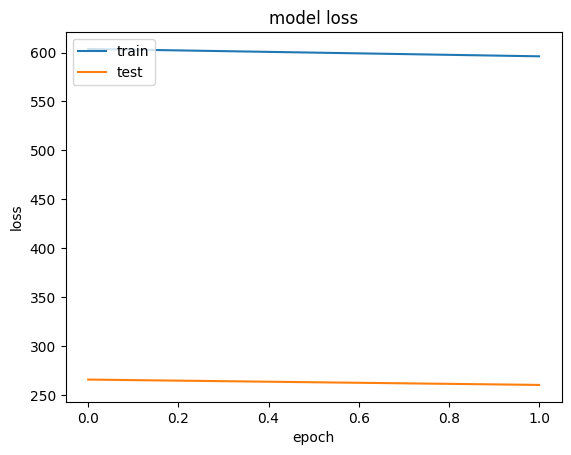

FINISH:  ['2023-04-18 19:33:49', 48, [603.701171875, 596.1537475585938], [265.8746337890625, 260.4143371582031]]
Whole dataset shape: (8736, 76, 79, 11)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_5 (TimeDis  (None, 96, 76, 79, 4)    132       
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 96, 38, 39, 4)    0         
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 96, 38, 39, 1)    17        
 tributed)                                                       
                                                                 
 time_distributed_8 (TimeDis  (None, 96, 19, 19, 1)    0         
 tributed)                       

2023-04-18 19:33:58.590012: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-18 19:33:58.591554: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-18 19:33:58.592663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/2


2023-04-18 19:33:59.559723: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [5824,76,79,8]
	 [[{{node Placeholder/_0}}]]
2023-04-18 19:33:59.559985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [5824,76,79,8]
	 [[{{node Placeholder/_0}}]]
2023-04-18 19:33:59.978974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/spl

      8/Unknown - 19s 2s/step - loss: 606.8632

2023-04-18 19:34:18.458644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1455,76,79,8]
	 [[{{node Placeholder/_0}}]]
2023-04-18 19:34:18.458921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1455,76,79,8]
	 [[{{node Placeholder/_0}}]]
2023-04-18 19:34:18.740682: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/spl

8/8 [==============================] - 21s 2s/step - loss: 606.8632 - val_loss: 266.2036
Epoch 2/2
8/8 [==============================] - 18s 2s/step - loss: 597.5586 - val_loss: 259.7060
dict_keys(['loss', 'val_loss'])


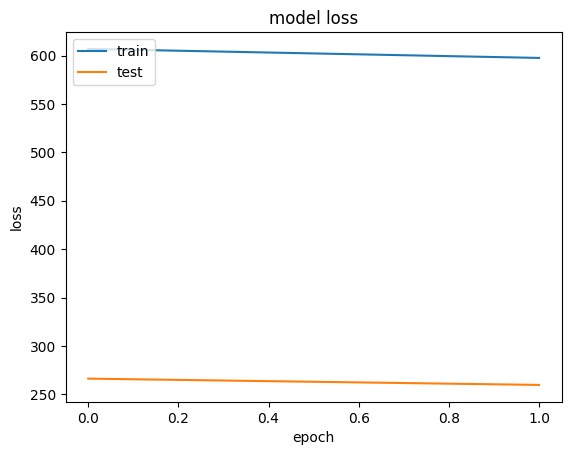

FINISH:  ['2023-04-18 19:34:39', 96, [606.8631591796875, 597.55859375], [266.20361328125, 259.7059631347656]]
Whole dataset shape: (8736, 76, 79, 11)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_10 (TimeDi  (None, 96, 76, 79, 4)    132       
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 96, 38, 39, 4)    0         
 stributed)                                                      
                                                                 
 time_distributed_12 (TimeDi  (None, 96, 38, 39, 1)    17        
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 96, 19, 19, 1)    0         
 stributed)                         

2023-04-18 19:34:48.966376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-18 19:34:48.968393: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-18 19:34:48.971109: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/2


2023-04-18 19:34:49.977153: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [5824,76,79,8]
	 [[{{node Placeholder/_0}}]]
2023-04-18 19:34:49.977395: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [5824,76,79,8]
	 [[{{node Placeholder/_0}}]]
2023-04-18 19:34:50.366189: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/spl

: 

: 

In [11]:
# create a CSV file and open it in write mode
with open(os.path.join(os.path.dirname(os.getcwd()), 'reports', 'iteration_results.csv'), mode='w', newline='') as file:

    writer = csv.writer(file)
    model_fn_list = ['12h', '24h', '36h', '48h', '72h', '96h', '5d', '6d', '7d']
    #create batch_size_list here so that we don't have memory issues for the training with large windows
    batch_size_list = [32, 32, 32, 16, 16, 16, 8, 8, 8]

    for i, window in enumerate([int(N_IN_24_H/2), N_IN_24_H, int(N_IN_24_H*3/2), N_IN_24_H*2, N_IN_24_H*3, N_IN_24_H*4, N_IN_24_H*5, N_IN_24_H*6, N_IN_24_H*7]):
        train_loss, val_loss = experiment(data, window_size = window+1, shift = 2, batch_size=32, lr=5e-3, epochs=200, vis=True, model_path = f'models/model{model_fn_list[i]}.h5')
        timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S") # get current timestamp
        row = [timestamp, window, train_loss, val_loss]
        print('FINISH: ', row)
        writer.writerow(row)

In [ ]:
# TODO - convert these to function so we can view any prediction
'''grid_info = os.path.join(os.path.dirname(os.getcwd()), "data", "raw", "ficheiros_WDL", "DISPOSITIVOS MOVEIS_QUADRICULAS", "DISPOSITIVOS MOVEIS_QUADRICULAS.xlsx")


# Create the 2d grid
dfs_grid = pd.read_excel(grid_info, sheet_name='em bruto', engine='openpyxl')
to_keep = ['grelha_x', 'grelha_y', 'wkt', 'grelha_id']

dfs_grid_filtered = dfs_grid[to_keep]
del(dfs_grid)

# grid indexs
grelha_x = dfs_grid_filtered['grelha_x'].values -1
grelha_y = dfs_grid_filtered['grelha_y'].values -1
grelha_id =  dfs_grid_filtered['grelha_id'].values 

grelha_id_2d = np.empty((grelha_y.max() +1, grelha_x.max()+1))
grelha_id_2d[:] = np.nan
pred_2d = grelha_id_2d.copy()
ground_truth_2d = grelha_id_2d.copy()

# Indices to map from
idx_2d = np.stack([grelha_y, grelha_x])

# Assign the elements to the regular rectangular grid

grelha_id_2d[tuple(idx_2d)] = grelha_id.ravel()
pred_2d[tuple(idx_2d)] = pred.ravel()
ground_truth_2d[tuple(idx_2d)] = ground_truth.ravel()


fig, axs = plt.subplots(1,2)

axs[0].set_title('Predicted')
axs[0].imshow(pred_2d)

axs[1].set_title('Ground truth')
axs[1].imshow(ground_truth_2d)

# axs[2].set_title('Error (%)')
# axs[2].imshow((pred_2d-ground_truth_2d)/(ground_truth_2d))'''

In [ ]:
'''truth_stats = stats.describe(ground_truth.flatten())
pred_stats = stats.describe(pred.flatten())

print("RESULTS")
print("MSE:", mean_squared_error(ground_truth, pred))
print("Ground Truth Stats:", truth_stats)
print("Predictions Stats: ", pred_stats)'''

In [ ]:
'''fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

ax1.hist(ground_truth.flatten(), bins=30)
ax1.set_title('Ground Truth')
ax1.axvline(truth_stats.mean, color='red', linestyle='dashed', linewidth=2)
ax1.axvline(truth_stats.mean - truth_stats.variance**0.5, color='gray', linestyle='dashed', linewidth=2)
ax1.axvline(truth_stats.mean + truth_stats.variance**0.5, color='gray', linestyle='dashed', linewidth=2)
ax1.text(0.05, 0.95, f"Mean: {truth_stats.mean:.2f}\nStd Dev: {truth_stats.variance**0.5:.2f}", transform=ax1.transAxes, fontsize=12, verticalalignment='top')

ax2.hist(pred.flatten(), bins=30)
ax2.set_title('Model Predictions')
ax2.axvline(pred_stats.mean, color='red', linestyle='dashed', linewidth=2)
ax2.axvline(pred_stats.mean - pred_stats.variance**0.5, color='gray', linestyle='dashed', linewidth=2)
ax2.axvline(pred_stats.mean + pred_stats.variance**0.5, color='gray', linestyle='dashed', linewidth=2)
ax2.text(0.05, 0.95, f"Mean: {pred_stats.mean:.2f}\nStd Dev: {pred_stats.variance**0.5:.2f}", transform=ax2.transAxes, fontsize=12, verticalalignment='top')

plt.show()'''